In [2]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl

import astropy.io.fits as pyfits

import os

#### Ορισμός γεωμετρικών στοιχείων

In [3]:
class Point:
    def __init__(self, x, y):
        self.x = x
        self.y = y

def get_distance(point1, point2):
    return np.sqrt((point1.x - point2.x)**2 + (point1.y - point2.y)**2)

origin = Point(0, 0)

class Circle:
    def __init__(self, center, radius):
        self.center = center
        self.radius = radius

    def is_in_ball(self, point):
        return get_distance(self.center, point) - self.radius <= 0
    
    def is_in_circle(self, point):
        return get_distance(self.center, point) - self.radius == 0
    
    def are_in_ball(self, points):
        return [self.is_in_ball(point) for point in points]
    
    def are_in_circle(self, points):
        return [self.is_in_circle(point) for point in points]
    
# απόσταση από pixel σε λεπτά
def pixel_to_arcmin(pixel):
    return pixel * 0.0392

#### Δεδομένα φωτογραφιών

In [4]:
# για κάποιον λόγο τίθεται η ενεργός διαδρομή στον φάκελο του VSCode 
# παρά τον φάκελο του αποθετηρίου, να το αλλάξετε αυτό ανά περίπτωση
# Υπενθύμιση ότι το `CODE_REPOS_1` είναι εμή μεταβλητή περιβάλλοντος,
# οπότε ο κώδικας *δεν* θα τρέξει αν δεν την αλλάξετε (ή δεν την ορίσετε)
work_directory = os.path.join(os.environ["CODE_REPOS_1"], "lab-team/")
event_path = os.path.join(work_directory, "events/")

event_files = [os.path.join(event_path, f) for f in os.listdir(event_path) if f.endswith(".evt.gz")]
event_number = len(event_files)
#source_fits_file = "source_data.fits.gz"

events = [pyfits.open(event_file) for event_file in event_files]

#### Ταξινόμηση φωτογραφιών χρονολογικά

In [5]:
event_headers = [event[1].header for event in events]
event_times = [(1/2)*(event_header["TSTOP"] + event_header["TSTART"])for event_header in event_headers]

events = [event for _, event in sorted(zip(event_times, events))]
event_times_sorted_immutable = sorted(event_times)
event_times_sorted = event_times_sorted_immutable.copy() # προχειροδουλειά που θα χρησιμεύσει αργότερα

event_headers = [event[1].header for event in events]
event_data = [event[1].data for event in events]

#### Επιλογή δοκιμαστικής φωτογραφίας
Πρέπει να επεξεργάζεστε ανά περίπτωση τα όρια των διαγραμμάτων (δεν είναι όμως απαραίτητο, καθώς τα διαγράμματα επιτελούν καθαρά σκοπούς οπτικοποίησης. Εφόσον το κέντρο βρίσκεται εντός των ορίων, δεν απαιτείται επεξεργασία)

In [6]:
event_index = 10

if event_index >= len(event_data):
    event_index = len(event_data) - 1
    print("\033[91mEvent index out of bounds, setting to last event\033[0m")

source_data = event_data[event_index]

source_x_limits = Point(350, 780)
source_y_limits = Point(400, 780)

#### Προβολή φωτογραφίας

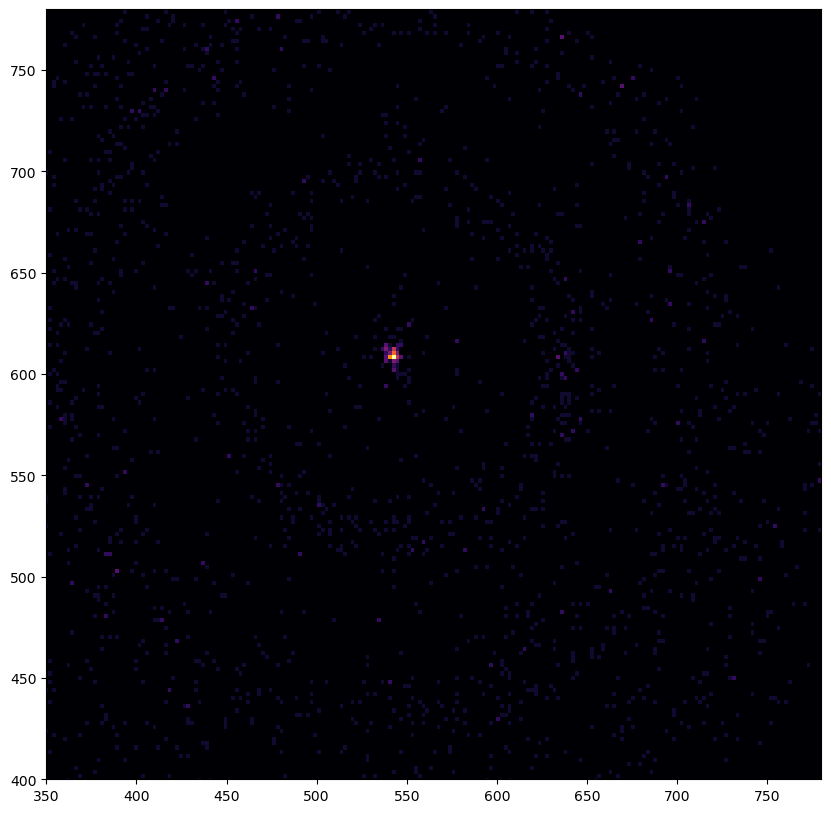

In [7]:
source_x_coords = source_data['X']
source_y_coords = source_data['Y']

plt.close('all')
plt.figure(1,figsize=(10,10))
plt.hist2d(source_x_coords, source_y_coords, bins=300, cmap='inferno')
plt.xlim(source_x_limits.x, source_x_limits.y)
plt.ylim(source_y_limits.x, source_y_limits.y)
plt.show()

#### Ορισμός Γεωμετρικών Χαρακτηριστικών εικόνας
Πρέπει να επεξεργάζεστε ανά περίπτωση το κέντρο του άστρου. Η ακτίνα δεν απαιτεί αλλαγή, καθώς είναι καθαρά για λόγους οπτικοποίησης

In [8]:
source_center_x = 540
source_center_y = 610
source_radius = 50

source_origin = Point(source_center_x, source_center_y)
source_circle = Circle(source_origin, source_radius)

#### Επικύρωση κέντρου
Χρησιμεύει για μια «με το μάτι» επιβεβαίωση της σωστής επιλογής του κέντρου. Μπορείτε επίσης να χρησιμοποιήσετε το αποτέλεσμα του διαγράμματος πλησίον του μηδενός για να επιβεβαιώσετε αν πήρατε καλά το κέντρο.

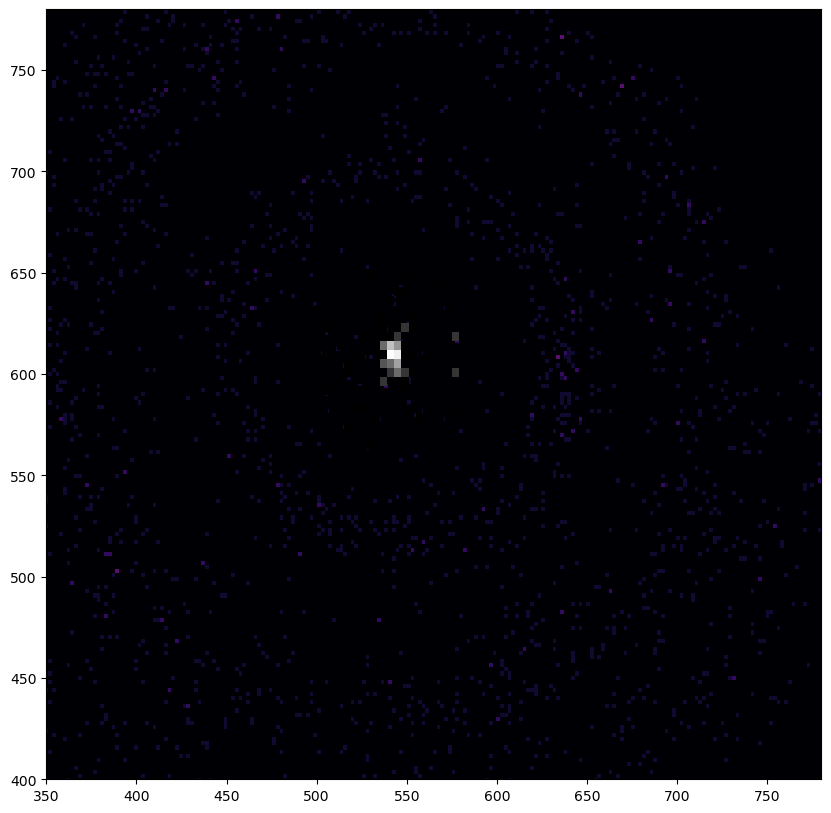

In [9]:
source_points = np.array([Point(x, y) for x, y in zip(source_x_coords, source_y_coords)])

source_origin_mask = source_circle.are_in_ball(source_points)

masked_source_points = source_points[source_origin_mask]
masked_source_x_coords = np.array([point.x for point in masked_source_points])
masked_source_y_coords = np.array([point.y for point in masked_source_points])

plt.close('all')
plt.figure(1,figsize=(10,10))
plt.hist2d(source_x_coords, source_y_coords, bins=300, cmap='inferno')
plt.hist2d(masked_source_x_coords, masked_source_y_coords, bins=20, cmap=plt.cm.gray,norm=mpl.colors.LogNorm())
plt.xlim(source_x_limits.x, source_x_limits.y)
plt.ylim(source_y_limits.x, source_y_limits.y)
plt.show()

#### Κατανομή
Η ιδέα της κατανομής είναι η εξής:
Ελέγχουμε για κάθε ανίχνευση την ακτίνα της από το εκτιμώμενο κέντρο και κάνουμε ιστόγραμμα με τις αποστάσεις

*Σημείωση: Οι κατανομές γίνονται πάνω σε όλες τις φωτογραφίες, όχι μόνο στην δοκιμαστική*

In [10]:
def get_distances_of_detections(data, origin_point = origin):
    x_coords = data['X']
    y_coords = data['Y']
    return np.array([get_distance(Point(x, y), origin_point) for x, y in zip(x_coords, y_coords)])

In [11]:
def get_all_distributions(events, origins, bin_count = 100):
    indices = range(len(events))
    for source, source_origin, index in zip(events, origins, indices):
        source_data = source[1].data
        source_header = source[1].header
        distances = get_distances_of_detections(source_data, source_origin)
        
        object_id = source_header['TELESCOP'] + source_header['OBS_ID']

        # Δεδομένα
        counts, bins = np.histogram(distances, bins = bin_count)
        bin_middle = (1/2)*(bins[1:] + bins[:-1]) # το μέσον κάθε μπάρας
        unit_bin_middle = [pixel_to_arcmin(bin) for bin in bin_middle]
        figure = plt.figure(1,figsize=(10,10))
        # Ρυθμίσεις
        plt.plot(unit_bin_middle, counts/unit_bin_middle) 
        plt.yscale("log")
        plt.grid("both")
        plt.title("Αριθμός ανιχνεύσεων ανά απόσταση από το κέντρο της πηγής \n[γεγονός: " + str(index) + ", κέντρο: (" + str(source_origin.x) + "," + str(source_origin.y) + ")" + ", ταυτοποίηση αντικειμένου: " + object_id + "]")
        plt.xlabel("Απόσταση από κέντρο [arcmin]")
        plt.ylabel("Αριθμός ανιχνεύσεων/απόσταση [$\log(1/arcmin)$]")
        # Αποθήκευση
        figure_name = "histograms/hist_" + str(index) + "_" + object_id + ".png"
        figure.savefig(figure_name)
        # Εμφάνιση
        plt.show()

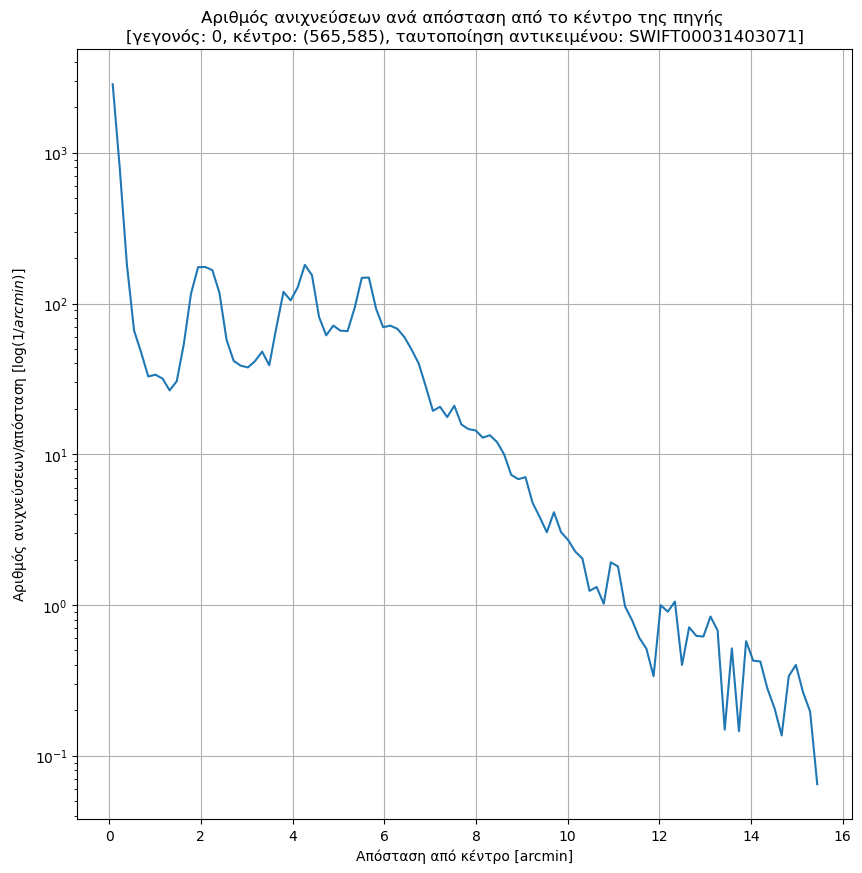

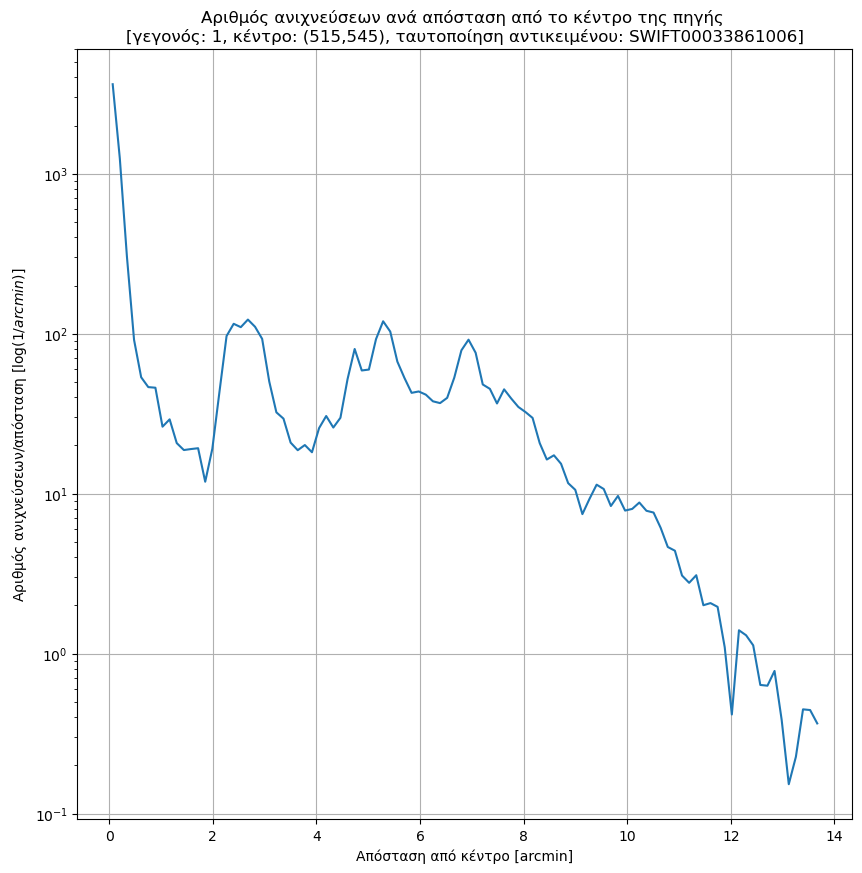

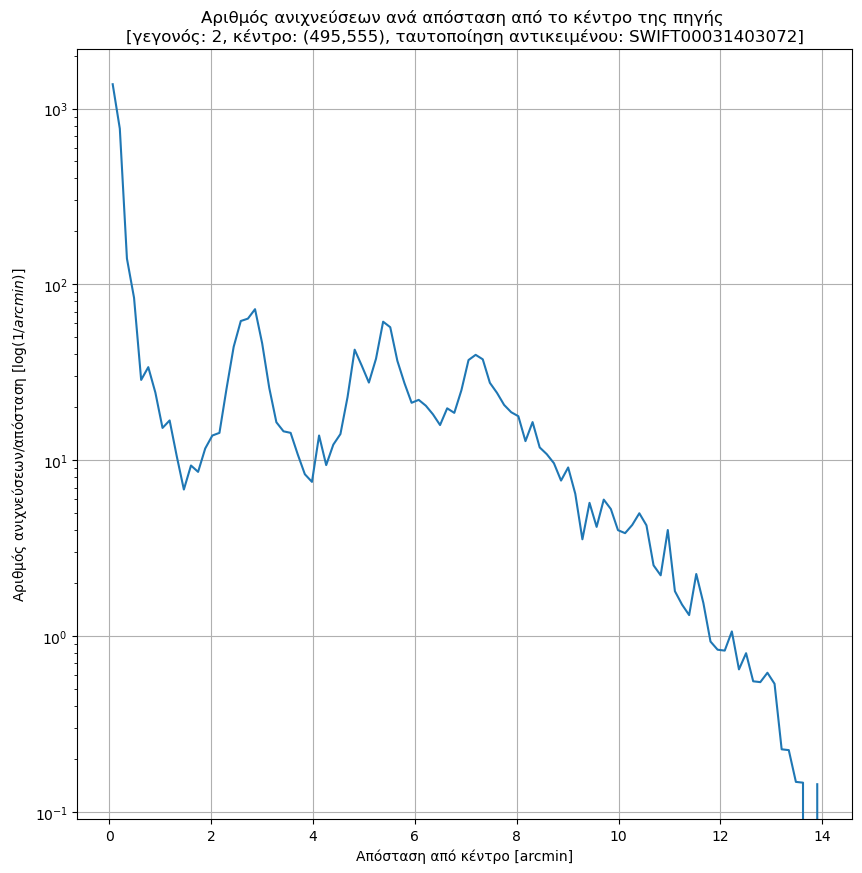

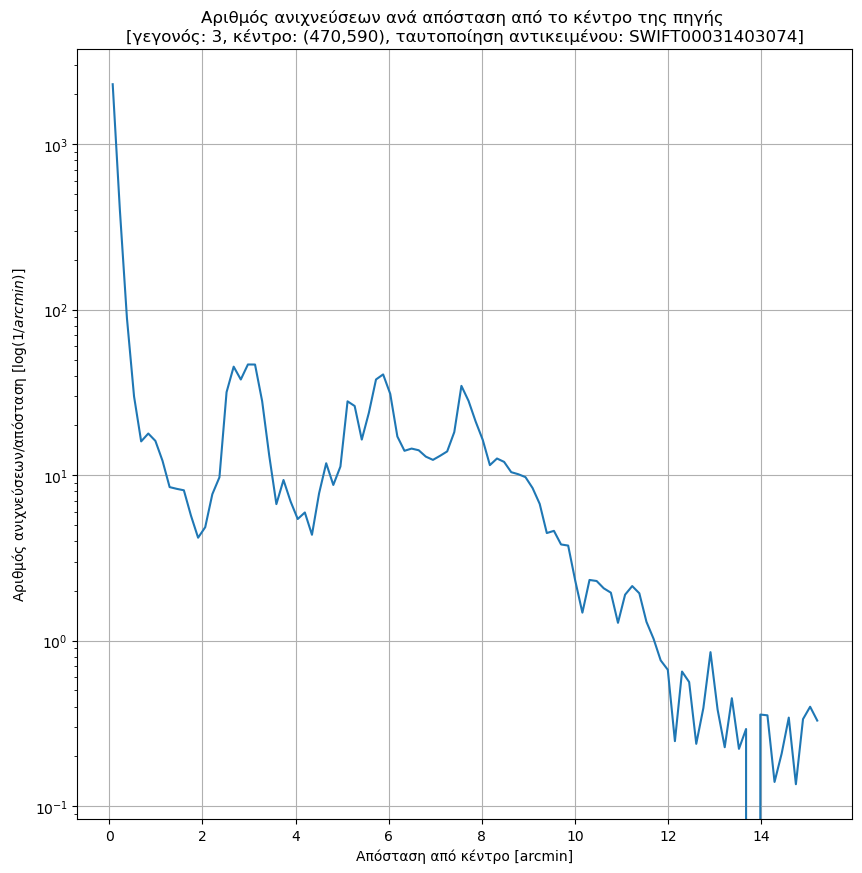

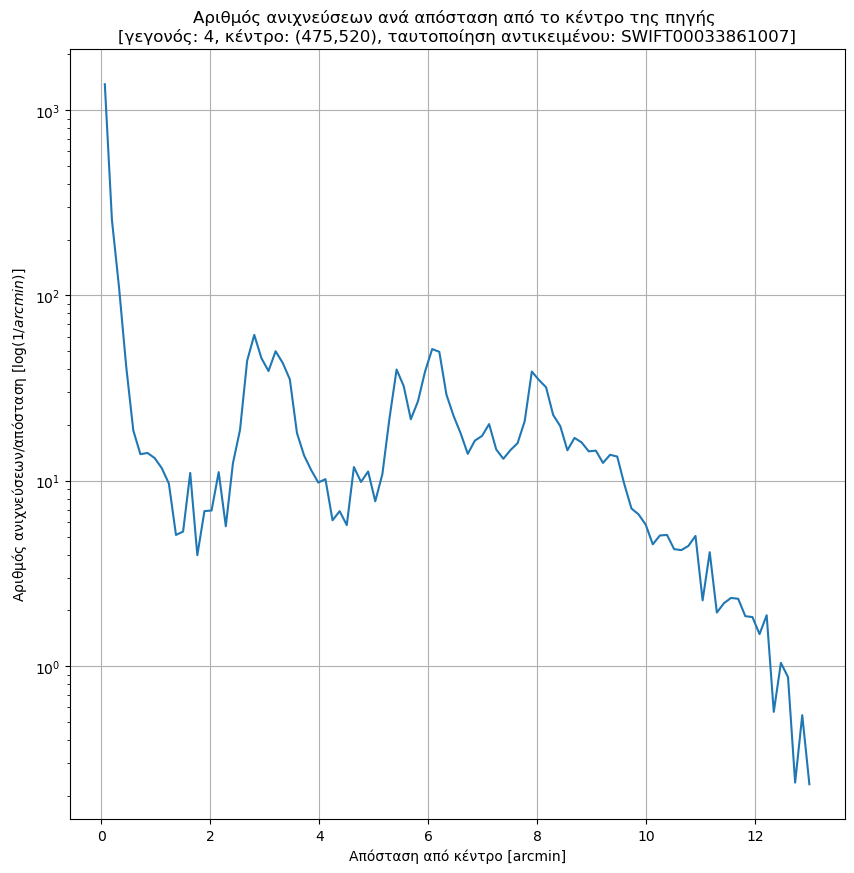

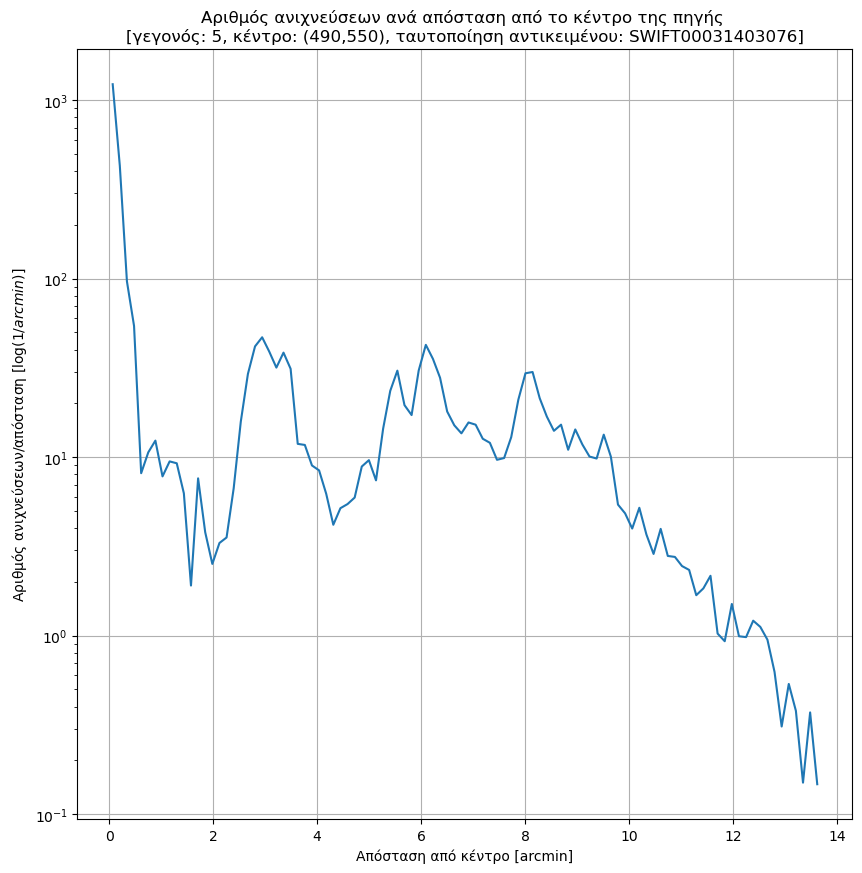

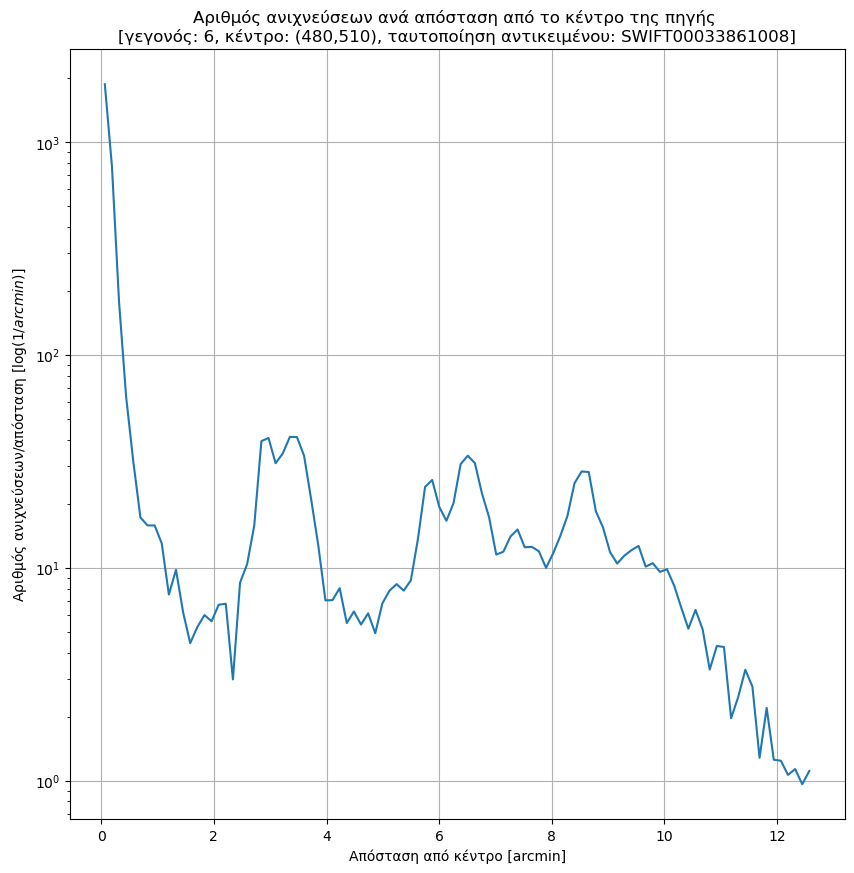

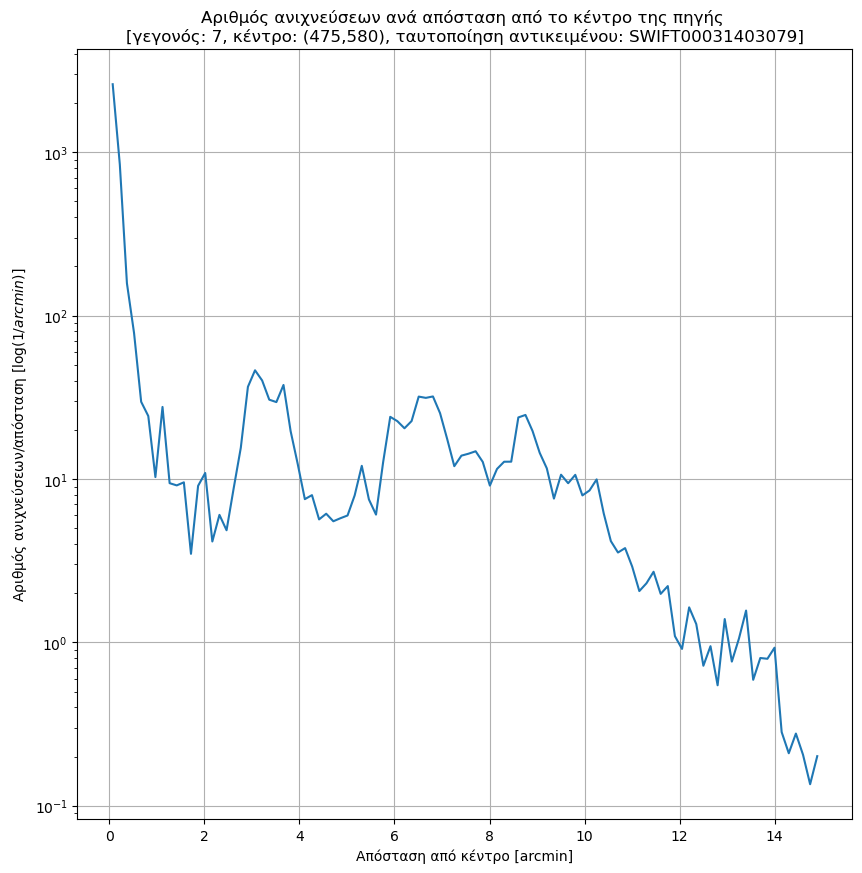

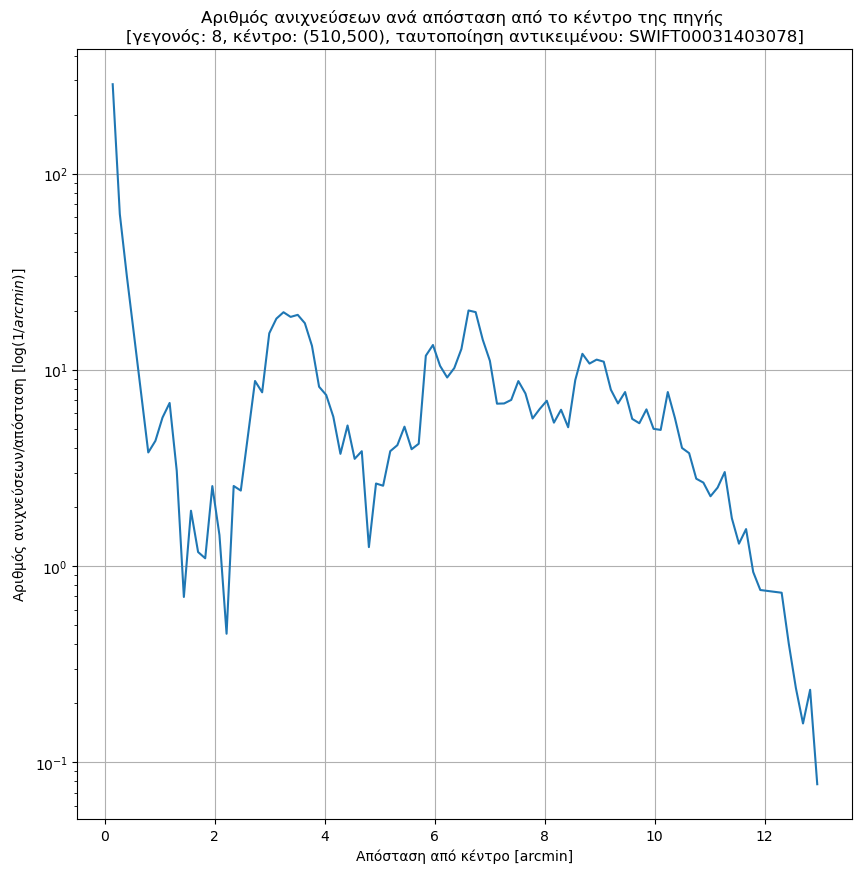

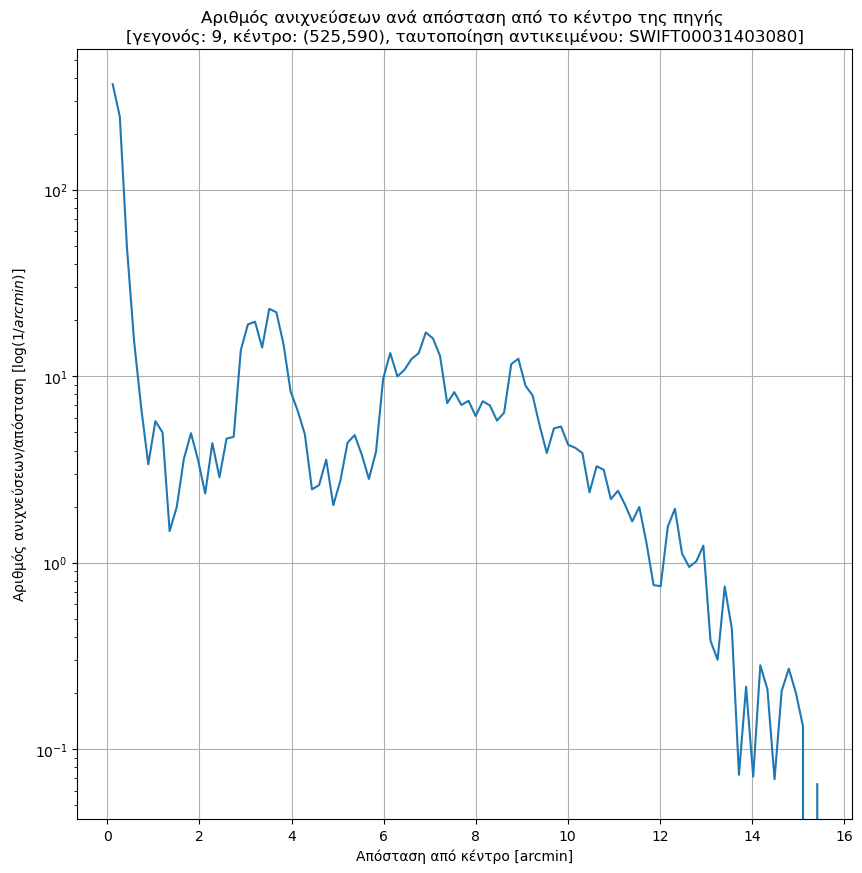

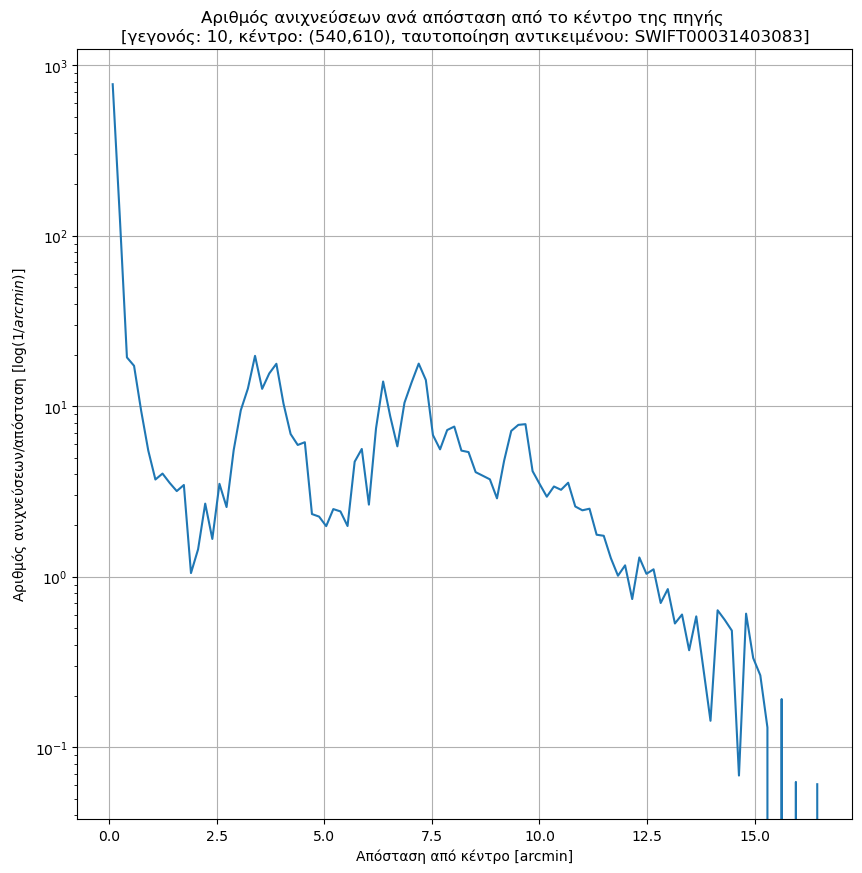

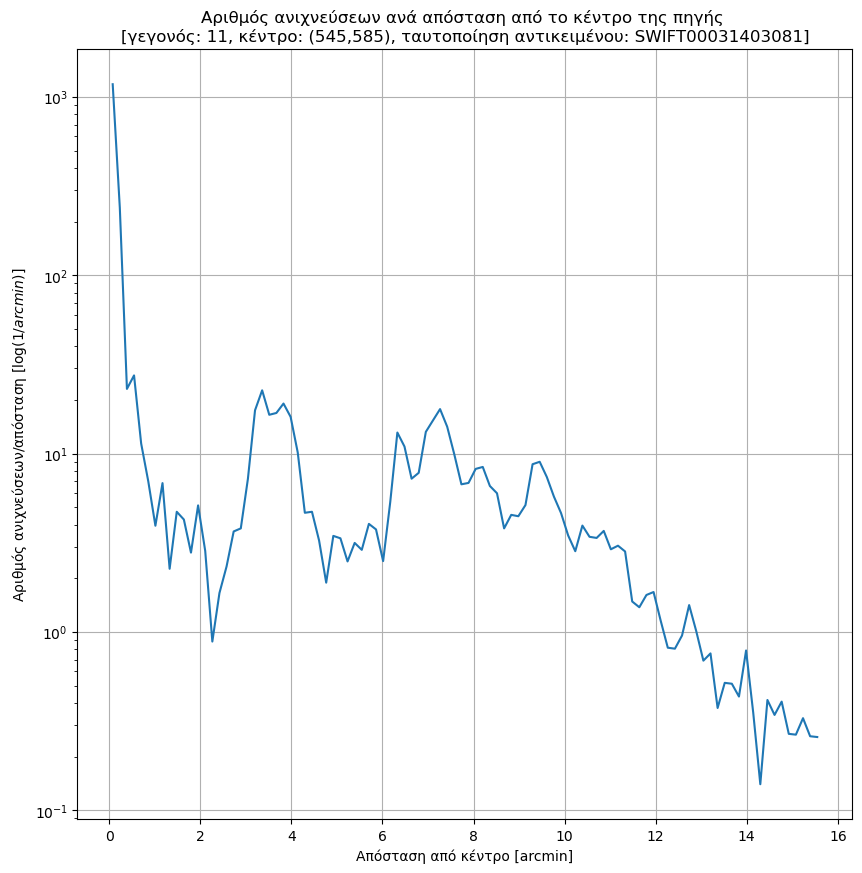

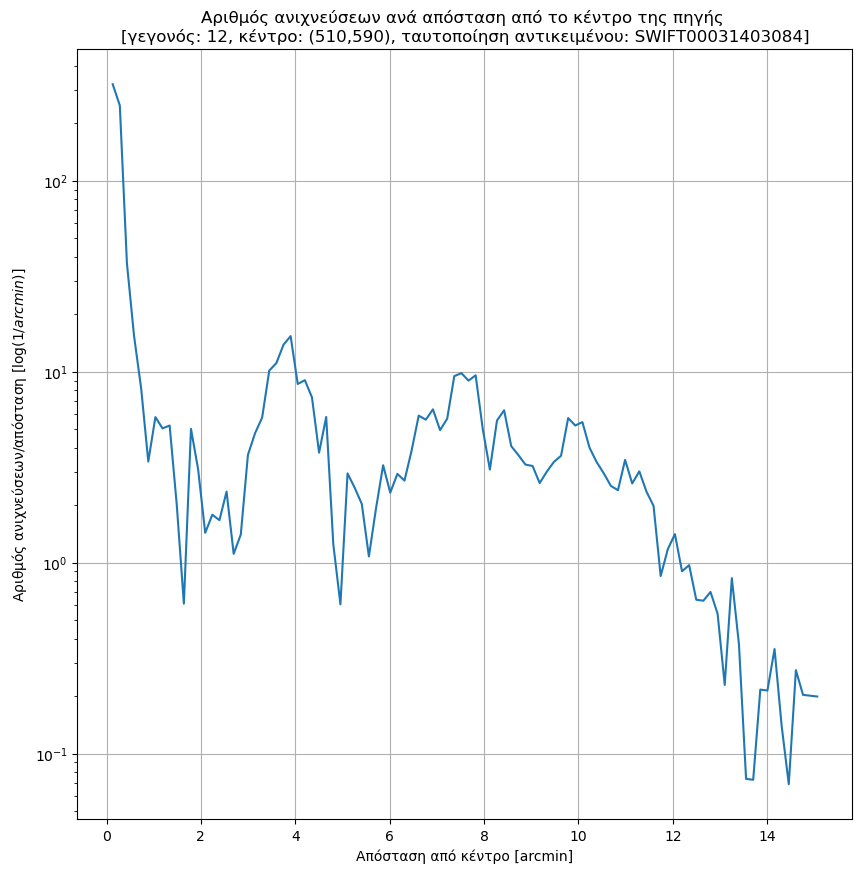

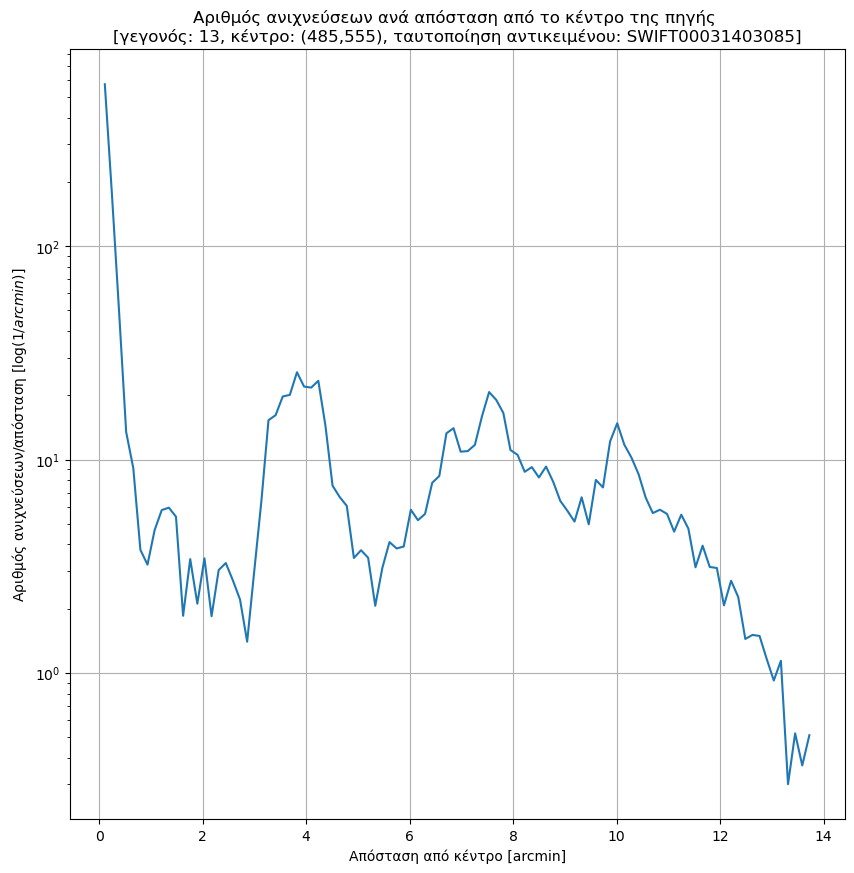

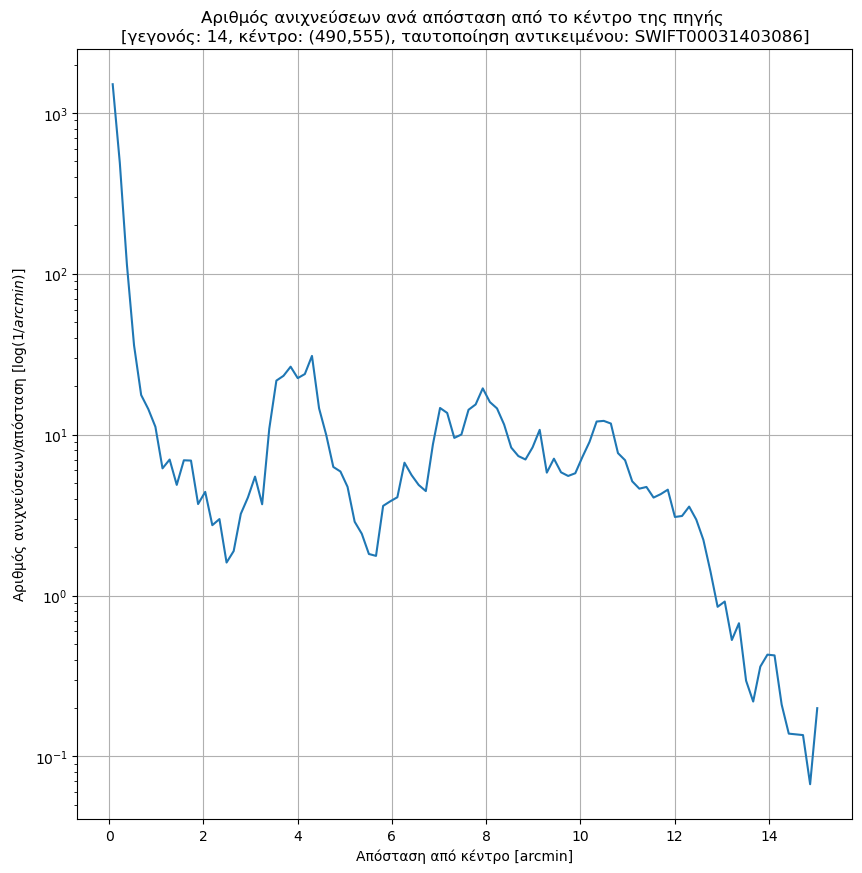

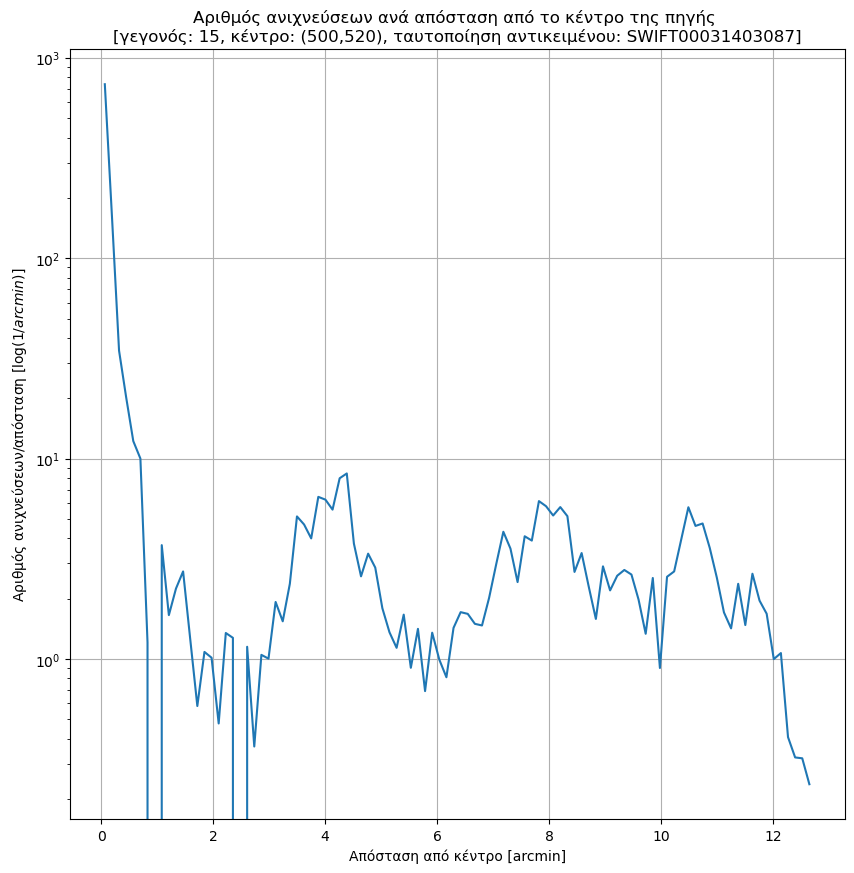

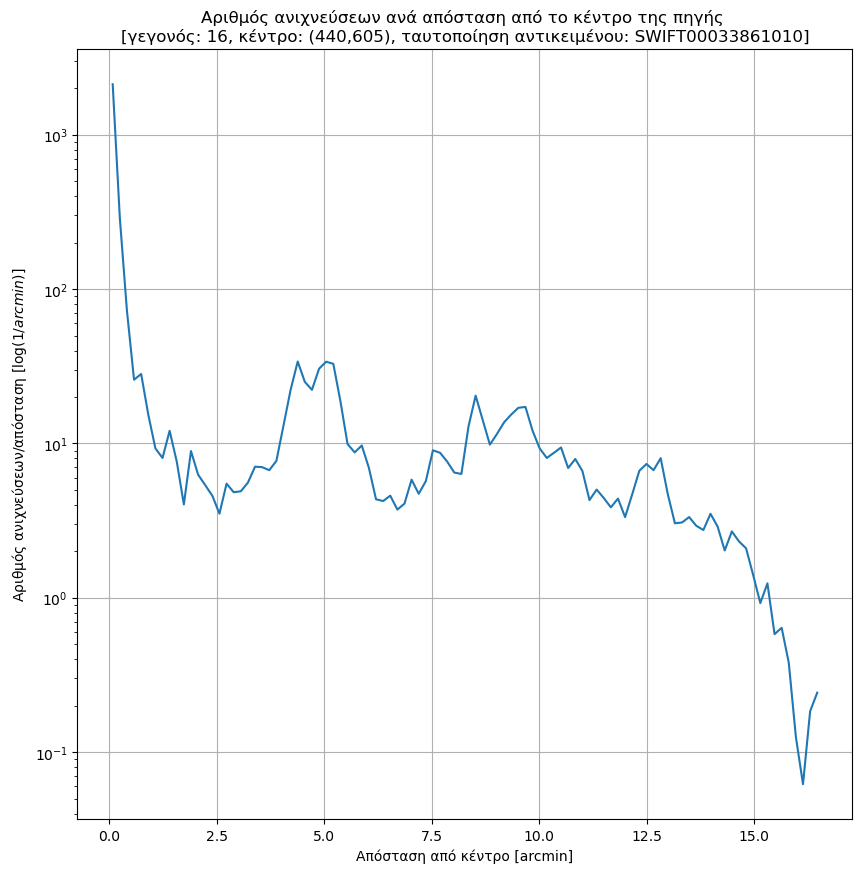

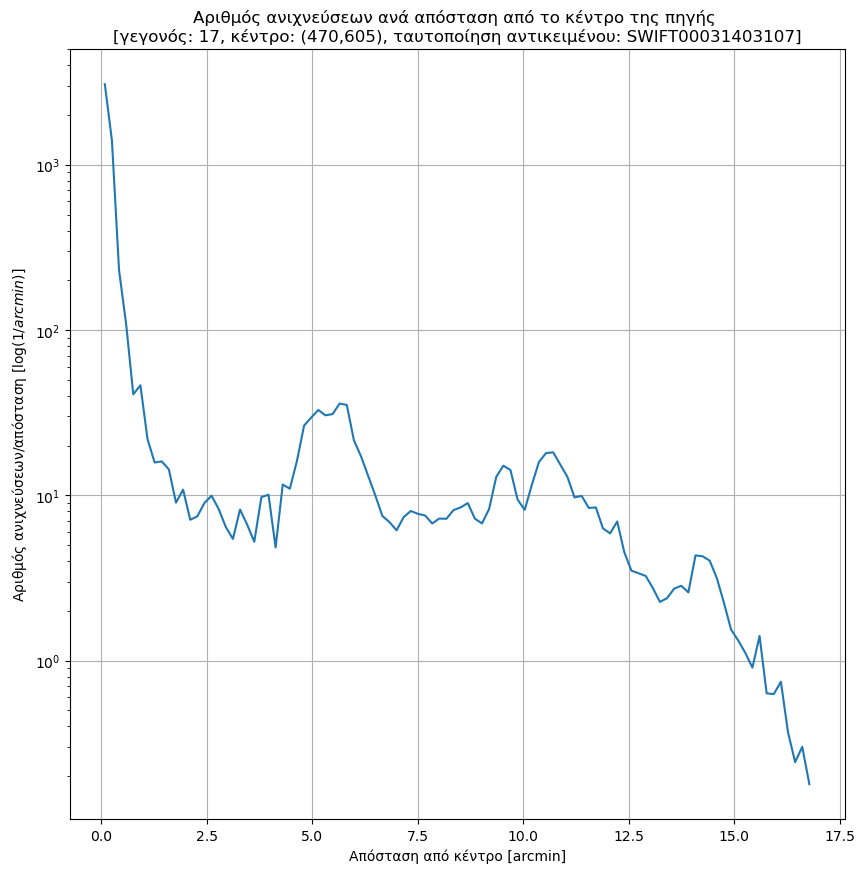

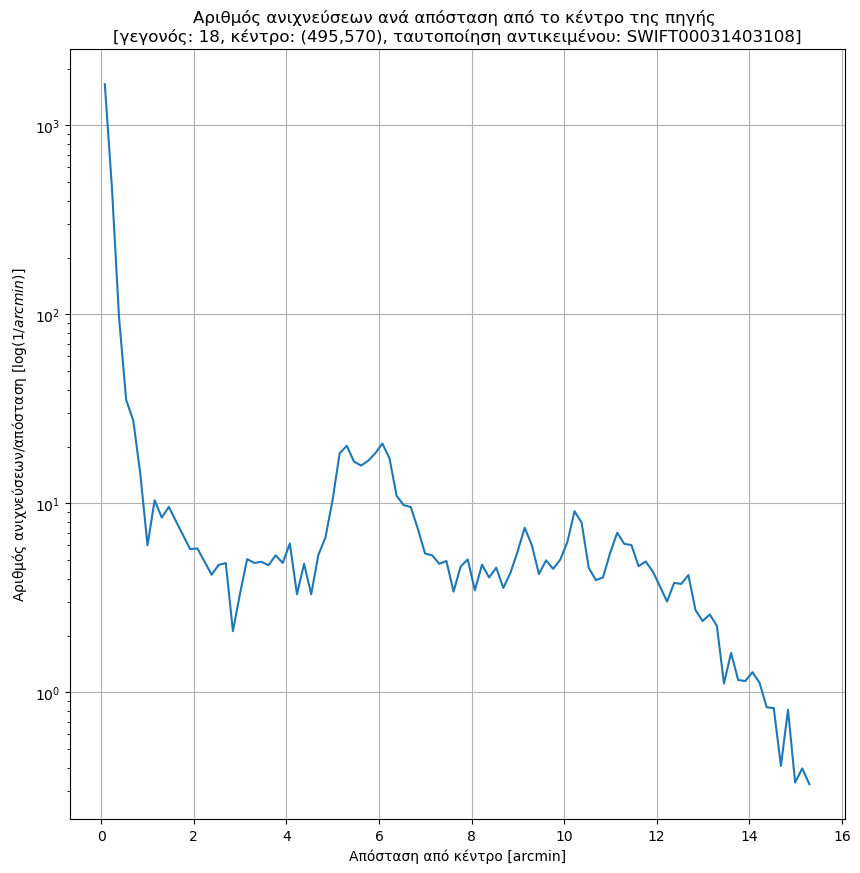

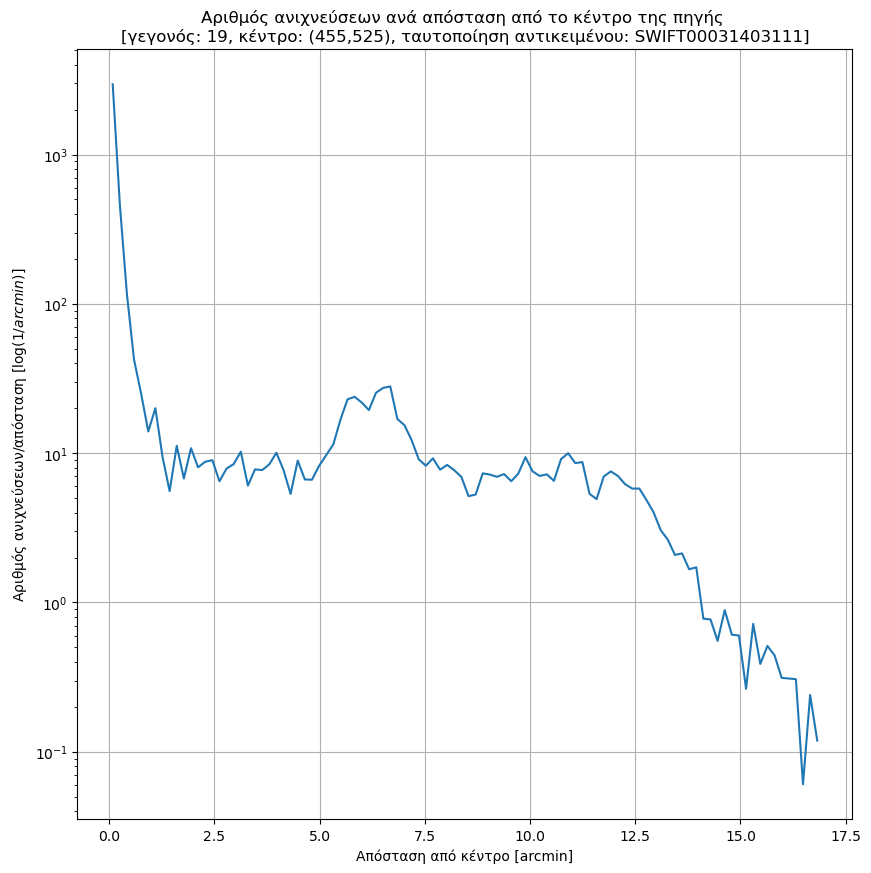

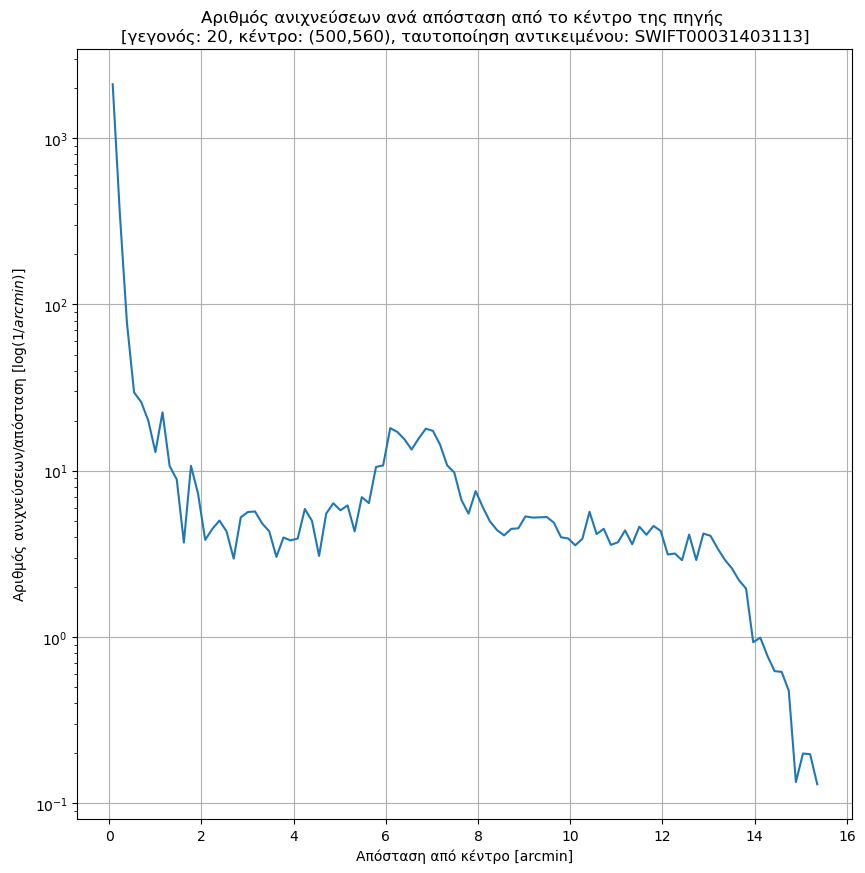

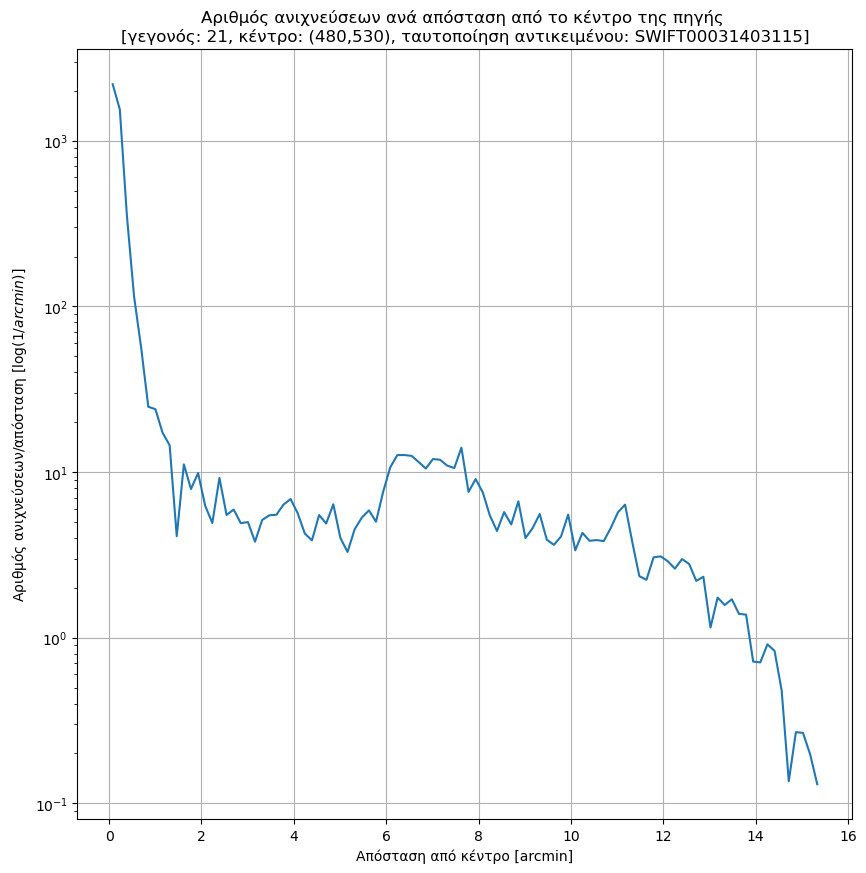

In [12]:
source_origins = [Point(565,585), Point(515,545), Point(495,555), Point(470, 590), Point(475,520), Point(490,550), Point(480,510), Point(475,580), Point(510,500), Point(525,590), Point(540,610), Point(545,585), Point(510,590), Point(485,555), Point(490,555), Point(500,520), Point(440,605), Point(470,605), Point(495,570), Point(455,525), Point(500,560), Point(480,530)]
bin_count = 100

plt.close('all')
get_all_distributions(events, source_origins, bin_count)

#### Χρονοσειρά

In [13]:
local_maxima_file = open("local_maxima.txt", "r")
local_maxima_lines = local_maxima_file.readlines()

local_maxima = np.array([]) # τα τοπικά μέγιστα για κάθε γεγονός
for line in local_maxima_lines:
    local_maxima = np.append(local_maxima, np.array([float(number) for number in line.split()]))

In [14]:
# Τα τοπικά μέγιστα στο local_maxima αφορούν 5 τοπικά μέγιστα που βρέθηκαν
# στα διαγράμματα, με τιμές τους ανά γεγονός, ήτοι ανά τον χρόνο. Τα πρώτα
# δύο μέγιστα έχουν 22 τιμές στον χρόνο, ενώ τα τρία τελευταία μόνο 20. 
# 
# Οι τιμές κάθε μεγίστου ανά τον χρόνο δεν βρίσκονται δίπλα η μία στην άλλη. Με
# άλλα λόγια, οι τιμές που αφορούν ένα τοπικό μέγιστο δεν βρίσκονται σε θέσεις 
# i, i+1 κτλ όπου i κάποιος φυσικός αριθμός.
# Αντ'αυτού, οι τιμές του κάθε τοπικού μεγίστου βρίσκονται στις θέσεις που ανήκουν
# στην ίδια κλάση ισοδυναμίας modulo 5 με τον αριθμό του μεγίστου. Άρα, οι τιμές, π.χ.
# του πρώτου (0) τοπικού μέγιστου βρίσκονται στις θέσεις 0, 5, 10, 15 και 20 του local_maxima.
# Οι τιμές του δεύτερου (1) τοπικού μέγιστου βρίσκονται στις θέσεις 1, 6, 11, 16 και 21 του local_maxima.
# κτλ.

local_maxima_per_time = [np.array([]), np.array([]), np.array([]), np.array([]), np.array([])]

for i in range(len(local_maxima)):
    if not local_maxima[i] == 0:
        local_maxima_per_time[i % 5] =np.append(local_maxima_per_time[i % 5], local_maxima[i])


snipped


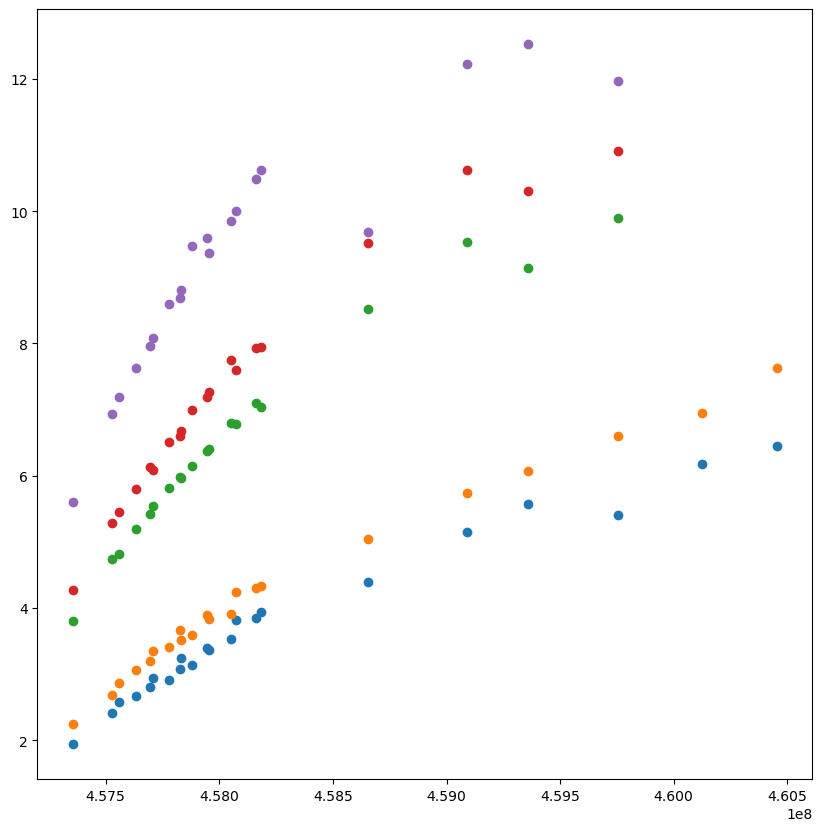

In [17]:
plt.close('all')
figure = plt.figure(1,figsize=(10,10))
snipped = False
event_times_sorted = event_times_sorted_immutable.copy() # να πού χρειάστηκε η προχειροδουλειά
for i in range(len(local_maxima_per_time)):
    if not snipped and i >= 2:
        event_times_sorted.pop()
        event_times_sorted.pop()
        snipped = True
        print("snipped")
    plt.scatter(event_times_sorted, local_maxima_per_time[i])
plt.show()
figure.savefig("maxima_scatter.png")
snipped = False

#### Προσαρμογή καμπύλης